In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

Mounted at /content/drive


---
_Here now check the step3 and step4 with this new environment._

### STEP#3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from environments.complete_environment import CompleteEnvironment
from data_generators.standard_generator import StandardDataGenerator
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB

In [3]:
src = 'src/basic005.json'

In [4]:
dg = StandardDataGenerator(filename=src)
margins = dg.get_margins()

In [5]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [6]:
selected_bid = 3

In [7]:
learners_to_test = [ThompsonSampling, UCB]
#learners_to_test = [UCB]
rewards_per_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []

In [8]:
for e in range(n_experiments):
    print(f'running experiment {e + 1}/{n_experiments}...\n')
    test_instances = []
    for learner in learners_to_test:
        test_instances.append((learner(arm_values=margins),
                               CompleteEnvironment(src=src)))
    for t in range(T):
        for learner, env in test_instances:
            learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            _ = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True) # past features not usefull here
            month_purchases = env.get_next_purchases_at_day(t, keep=False, filter_purchases=True)
            if month_purchases is not None:
                for arm, n_purchases in zip(past_arms, month_purchases):
                    learner.update_single_future_purchase(arm, n_purchases)
            pulled_arm = learner.pull_arm()
            daily_reward, _, _ = env.day_round(pulled_arm, selected_bid=selected_bid, fixed_adv=True)
            for outcome, cost in daily_reward:
                learner.update(pulled_arm, outcome, cost)
    for learner, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.LEARNER_NAME].append(learner.daily_collected_rewards)

running experiment 1/10...

running experiment 2/10...

running experiment 3/10...

running experiment 4/10...

running experiment 5/10...

running experiment 6/10...

running experiment 7/10...

running experiment 8/10...

running experiment 9/10...

running experiment 10/10...



In [9]:
margins = dg.get_margins()
classes = dg.get_classes()
conversion_rates = dg.get_conversion_rates(mode='all')
future_purchases = dg.get_future_purchases(mode='all')
number_of_clicks = dg.get_daily_clicks(mode='all')

costs_per_click = dg.get_costs_per_click(mode='aggregate', bid=selected_bid)
fixed_cost = costs_per_click[selected_bid]
fixed_n_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[selected_bid]).astype(int)
fractions = dg.get_class_distributions(selected_bid)

temp = (margins * np.average(conversion_rates * (1 + future_purchases),
                             axis=0,
                             weights=fractions) - fixed_cost) * fixed_n_clicks
aggr_opt_arm = np.argmax(temp)
aggr_opt = np.max(temp)

disaggr_opt = 0
opt_arms = []
disaggr_costs = dg.get_costs_per_click(mode='all')
for i, _ in enumerate(conversion_rates):
    t = (margins * conversion_rates[i] * (1 + future_purchases[i]) - disaggr_costs[i, selected_bid]) * \
                number_of_clicks[i, selected_bid]
    opt_arm = np.argmax(t)
    opt_value = np.max(t)
    opt_arms.append(opt_arm)
    disaggr_opt += opt_value

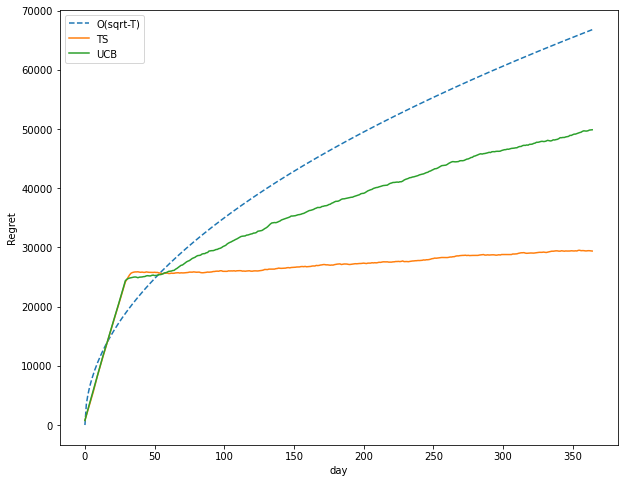

In [13]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(3500*np.sqrt(np.linspace(0,364,365)), '--')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(aggr_opt - val, axis=0)))


#plt.axvline(x=cg_start_from, color='r', linestyle='--')
#for val in days_of_split.values():
#    avg_days = np.mean(val, axis=0)
#    for day in avg_days:
#        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(['O(sqrt-T)']+list(rewards_per_experiment.keys()))
plt.show()

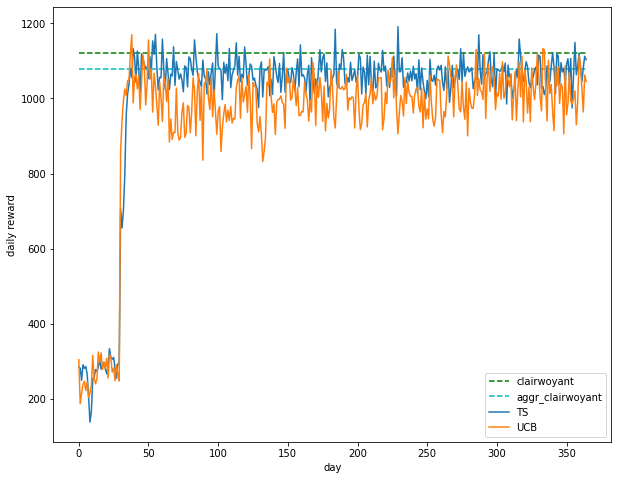

In [14]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()

---
### STEP#4

In [15]:
from learners.pricing.contextual_learner import ContextualLearner
from utils.context_generator import ContextGenerator

In [16]:
selected_bid = 3
T = 365
n_experiments = 5
learners_to_test = [ThompsonSampling, UCB]
cg_start_from = 60
cg_confidence = 0.1
cg_frequency = 10

features = dg.get_features() 
fractions = dg.get_class_distributions(selected_bid)
bandit_args = {
            'arm_values': dg.get_margins()
}

In [17]:
rewards_per_experiment = {}
context_split_per_experiment = {}
days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    days_of_split[learner.LEARNER_NAME] = []

In [20]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\nrunning experiment {e + 1}/{n_experiments}...\n')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (context_learner,
             CompleteEnvironment(src=src),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=1))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            #print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            past_features = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True)
            month_purchases = env.get_next_purchases_at_day(t, keep=True, filter_purchases=True)
            if month_purchases is not None:
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards, _, _ = env.day_round(pulled_arms, selected_bid=selected_bid, fixed_adv=True)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)
            
            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, 
                                                 daily_rewards, 
                                                 daily_users_features,
                                                 next_purchases=month_purchases, 
                                                 past_pulled_arms=past_arms,
                                                 past_features=past_features)
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())
        days_of_split[learner.base_learner_class.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])
    
    # end -> save rhe results.


running experiment 1/5...


-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']

Analysis of the feature `feature-2`...

Analysis of the feature `feature-1`...
	Values after the split: [3.051542376163198, 3.1088523101376486]
	Value before the split: 2.941983683036304

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False} and {'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-2', 'feature-1']

Analysis of the feature `feature-2`...

Analysis of the feature `feature-1`...
	Values after the split: [2.729937587864532, 2.8355762417540396]
	Value before the split: 2.665380175184923

	"Best feature: "feature-1
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False} and {'fe

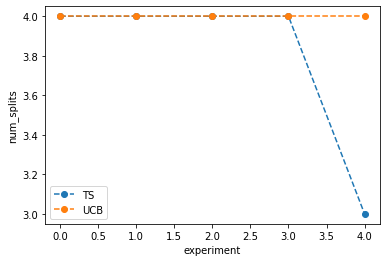

In [21]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_per_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_per_experiment.keys())
plt.show()

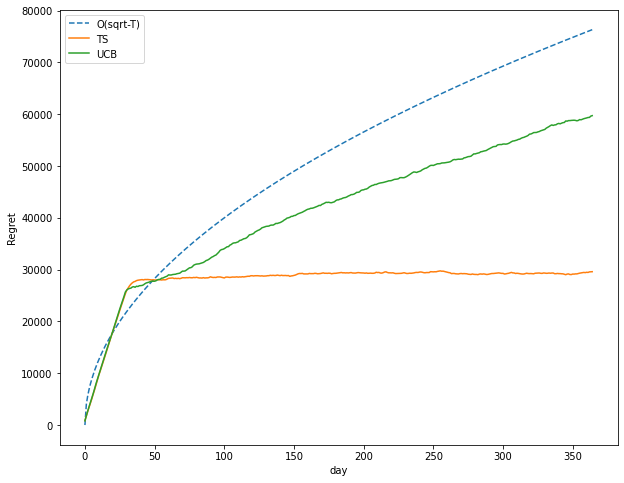

In [23]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
plt.plot(4000*np.sqrt(np.linspace(0,364,365)), '--')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(disaggr_opt - val, axis=0)))

plt.legend(['O(sqrt-T)']+list(rewards_per_experiment.keys()))
plt.show()

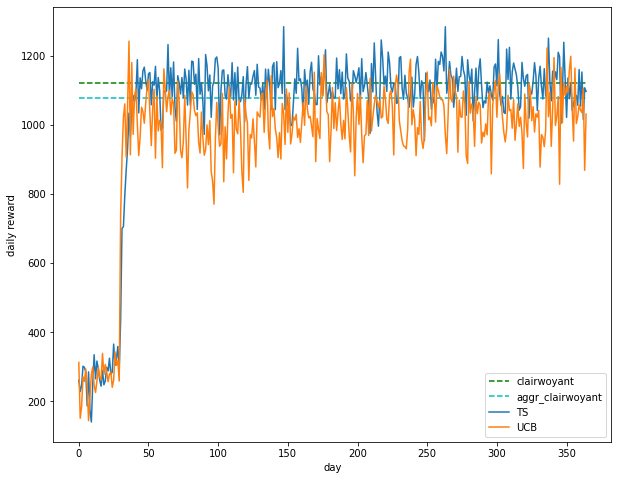

In [24]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()